In [1]:
# Python code written by Dong-Sig Han. 2016-01 ~ 2016-02
import sys
from glob import glob
from parseBabiTask import *
from DMN import DMN
import time
import numpy as np
import theano
import theano.tensor as T 
import lasagne
from itertools import chain
from lasagne.regularization import regularize_layer_params, l2

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)
/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
# load training datasets.
base_dir = 'tasks_1-20_v1-2/en/'
train_data_path = [glob(base_dir + 'qa' + str(t) + '_*_train.txt')[0] for t in xrange(1, 21)]
word_dict = dict(nil = 0)
story, questions, qstory = parseBabiTask(train_data_path, word_dict, 11, 228, False)

# load testing datasets.
test_data_path = [glob(base_dir + 'qa' + str(t) + '_*_test.txt')[0] for t in xrange(1, 21)]
test_story, test_questions, test_qstory = parseBabiTask(test_data_path, word_dict, 11, 228, False)

# get an inverted dictionary that keys and values have been switched
# e.g. word_dict['Mary'] -> 0; inv_word_dict[0] -> 'Mary'
inv_word_dict = {v: k for k, v in word_dict.items()}

def get_word_size(sentence):
    return np.count_nonzero(sentence)

# get word size of each sentence of inputs and questions
story_word       = np.zeros(story.shape[0:2],       np.int32)
qstory_word      = np.zeros(qstory.shape[0:1],      np.int32)
test_story_word  = np.zeros(test_story.shape[0:2],  np.int32)
test_qstory_word = np.zeros(test_qstory.shape[0:1], np.int32)

for i in xrange(story_word.shape[0]):
    for j in xrange(story_word.shape[1]):
        story_word[i, j]= get_word_size(story[i, j])
for i in xrange(qstory_word.shape[0]):
    qstory_word[i]= get_word_size(qstory[i])
for i in xrange(test_story_word.shape[0]):
    for j in xrange(test_story_word.shape[1]):
        test_story_word[i, j]= get_word_size(test_story[i, j])
for i in xrange(test_qstory_word.shape[0]):
    test_qstory_word[i]= get_word_size(test_qstory[i])


task       = range(1,21) # load all.
#task        = [20]#, 2, 3]#, 3]#, 3,7, 8] # load certain tasks.
train_size  = int(questions.shape[0]*0.05*len(task))
ordered     = np.concatenate([np.arange(1000*(t-1), 1000*t, dtype=np.int32) for t in task], axis=0) 
rp          = np.random.permutation(ordered)
train_range = rp[0:int(1.0 * train_size)]
# RECENTLY, I DO NOT USE VALIDATION SET BECAUSE IT IS USELESS IN EPISODIC QA PROBLEMS.
val_range   = rp[int(0.95 * train_size):train_size] 
test_size   = train_size

# function for laoding batch data
def batch_inputs_and_outputs(batch_start, batch_end,
                             story, questions, qstory,
                             story_word, qstory_word,
                             arr=ordered, time_noise=False, ep_pass=3, max_sentence=50, mapping=None):
    story_ind     = questions[arr[batch_start:batch_end],0]
    sentence_ind  = questions[arr[batch_start:batch_end],1]
    target_answer = questions[arr[batch_start:batch_end],2]
    
    input_sentence = sentence_ind+1
   
    input_sentence_generalized = np.minimum(input_sentence, max_sentence)
    input_sentence_cutoff = input_sentence - input_sentence_generalized 
    
    batch_max_sentence = np.max(input_sentence_generalized)
    input_word     = np.zeros((batch_end-batch_start,batch_max_sentence), dtype=np.int32)
    
    for i in xrange(len(input_word)):
        c = input_sentence_cutoff[i]
        input_word[i] = np.pad(story_word[story_ind[i], c:(c+input_sentence_generalized[i])],
                               (0,batch_max_sentence-input_sentence_generalized[i]),
                               mode='constant',
                               constant_values=0)
    
    batch_max_word = np.max(input_word)
    input = np.zeros((batch_end-batch_start,batch_max_sentence,batch_max_word), dtype=np.int32)
    for i in xrange(len(input)):
        c = input_sentence_cutoff[i]
        input[i] = np.pad(story[story_ind[i], c:(c+input_sentence_generalized[i]), :batch_max_word],
                          ((0,batch_max_sentence-input_sentence_generalized[i]),(0,0)),
                          mode='constant',
                          constant_values=0)
    '''
    batch_max_sentence = np.max(input_sentence)
    input_word     = story_word[story_ind,:batch_max_sentence]
    input          = story[story_ind,:batch_max_sentence,:np.max(input_word)]
    '''
    if time_noise:
        time_sequence = np.arange(int(batch_max_sentence * 1.2),dtype=np.int32)
        np.random.shuffle(time_sequence)
        input_time = np.sort(time_sequence[:batch_max_sentence])[::-1]
    else:
        input_time = np.arange(batch_max_sentence,dtype=np.int32)[::-1] 
    
    question_word = np.reshape(qstory_word[arr[batch_start:batch_end]],
                               (batch_end-batch_start, 1))
    question      = np.reshape(qstory[arr[batch_start:batch_end],:np.max(question_word)],
                               (batch_end-batch_start, 1, np.max(question_word)))
     
    gate_supervision = questions[arr[batch_start:batch_end],3:3+ep_pass].copy()
    
    for i in xrange(gate_supervision.shape[0]):
        for j in xrange(gate_supervision.shape[1]):
            if gate_supervision[i,j] < 0:
                #gate_supervision[i,j] = np.random.randint(batch_max_sentence)
                gate_supervision[i,j] = gate_supervision[i,j-1]

    gate_supervision = (gate_supervision - input_sentence_cutoff.reshape(-1,1)).reshape(-1)
            
    for i in xrange(len(gate_supervision)):
        if gate_supervision[i] < 0:
            gate_supervision[i] = np.random.randint(batch_max_sentence)
    
    if mapping is None:
        return (input, input_sentence_generalized, input_word, input_time,
            question, question_word,
            target_answer, gate_supervision)
    else:
        return (mapping[input], input_sentence_generalized, input_word, input_time,
            mapping[question], question_word,
            mapping[target_answer], gate_supervision)

def single_input_and_output(idx, story, questions, qstory,
                            story_word, qstory_word,
                            arr=ordered, time_noise=False, ep_pass=3, mapping=None):
    return batch_inputs_and_outputs(idx,idx+1,story,questions,qstory,
                                    story_word,qstory_word,arr,time_noise, ep_pass, mapping=mapping)

In [3]:
male_person_word = ['jason', 'antoine', 'brian', 'fred', 'daniel', 'bernhard', 'jeff', 'julius', 'john', 'greg']
female_person_word = ['emily', 'jessica', 'winona', 'julie', 'mary', 'lily', 'sandra']
get_word    = ['picked', 'received', 'grabbed']
put_word    = ['left', 'dropped', 'put down', 'discarded']
go_word     = ['went', 'moved', 'journeyed', 'travelled']
place_word  = ['office', 'bedroom', 'bathroom', 'kitchen', 'hallway', 'garden']

def switch_mapping(current_mapping, word_dict, word_class):
    idx = [word_dict[word] for word in word_class]
    idx_shuffled = np.random.permutation(idx)
    for i in xrange(len(idx)):
        current_mapping[idx[i]] = idx_shuffled[i]
    return current_mapping

In [4]:
#configuration
config = dict()
config['max_word']        = story.shape[2]
config['max_sentence']    = story.shape[1]
config['max_answer_word'] = 1
config['voc_size']        = len(word_dict)
config['hid_state_size']  = 300
config['max_gate_supervision'] = np.max(map(lambda x: np.sum(x >= 0), questions[:,3:14]))
config['ep_pass']         = 3

#use glove vectors
config['pretrained_word_embedding'] = True
glove_words = []
glove_vectors = []
filename = "glove.6B.bAbI.txt"
with open(filename) as f:
    for line in f:
        l = line.strip().split(' ')
        glove_words.append(l[0])
        glove_vectors.append(np.asarray(map(np.float32, l[1:]), dtype=theano.config.floatX))
glove = dict(zip(glove_words, glove_vectors))

word_embedding_matrix = np.zeros((len(word_dict), config['hid_state_size']), dtype=np.float32)

for i in xrange(len(word_dict)):
    words = inv_word_dict[i].split(',')
    for j in xrange(len(words)):
        if   words[j] == 'n':
            word_embedding_matrix[i,:] += glove['north']
        elif words[j] == 's':
            word_embedding_matrix[i,:] += glove['south']
        elif words[j] == 'e':
            word_embedding_matrix[i,:] += glove['east']
        elif words[j] == 'w':
            word_embedding_matrix[i,:] += glove['west']
        elif glove.has_key(words[j]):
            word_embedding_matrix[i,:] += glove[words[j]]
        else :
            word_embedding_matrix[i,:] += np.random.normal(0, 0.2, 300).astype(np.float32)
            print ('Word \'' + words[j] + '\' was not found in GloVe. Replacing its embedding with a radom vector')
# It will be used in Initialization of Semantic Memory Module
config['word_embedding'] = word_embedding_matrix

Word 'nil' was not found in GloVe. Replacing its embedding with a radom vector


In [5]:
dmn = DMN(config, word_dict)

In [6]:
# compile prediction and gate_activation
prediction = T.reshape(lasagne.layers.get_output(dmn.A), (-1, config['voc_size']))
gate_activation = lasagne.layers.get_output(dmn.E_G)
predict_fn = theano.function([dmn.input_var, dmn.input_sentence_var, dmn.input_word_var, dmn.input_time_var,
                              dmn.question_var, dmn.question_word_var,
                              dmn.word_dropout_var, dmn.epmem_dropout_var], prediction)
gate_fn = theano.function([dmn.input_var, dmn.input_sentence_var,  dmn.input_word_var, dmn.input_time_var,
                           dmn.question_var, dmn.question_word_var,
                           dmn.word_dropout_var], gate_activation)

In [7]:
# An example question in test set 
input, i_s, i_w, i_t, q, q_w, t, g_s = single_input_and_output(1999, test_story, test_questions, test_qstory,
                                                               test_story_word, test_qstory_word, time_noise=False,
                                                               ep_pass=config['ep_pass'])
cnt = -1
for j in xrange(i_s[0]):
    cnt += 1
    print str(cnt)+':',
    for k in xrange(i_w[0,j]):
        print inv_word_dict[input[0,j,k]],
    print('.')
for i in xrange(q_w[0,0]):
    print inv_word_dict[q[0,0,i]],
print('?')

answer = predict_fn(input, i_s, i_w, i_t, q, q_w, 0, 0)
print('=======================================')
print('The model predicted \''+inv_word_dict[np.argmax(answer)] + '\', where the target is \'' + inv_word_dict[t[0]] + '\'')

0: john took the football there .
1: john left the football .
2: mary went back to the bathroom .
3: sandra got the football there .
4: daniel journeyed to the kitchen .
5: john journeyed to the bedroom .
6: sandra dropped the football .
7: mary moved to the kitchen .
8: daniel grabbed the apple there .
9: mary went to the bathroom .
10: mary moved to the bedroom .
11: john went back to the bathroom .
12: daniel discarded the apple there .
13: mary travelled to the kitchen .
14: sandra picked up the football there .
15: sandra left the football there .
16: mary went to the hallway .
17: daniel got the apple there .
18: daniel travelled to the hallway .
19: mary took the football there .
20: john travelled to the hallway .
21: mary put down the football .
22: mary went back to the bedroom .
23: john went back to the office .
where is the football ?
The model predicted 'wolf', where the target is 'hallway'


In [8]:
# Define loss and compile traing and valdidation functions.

# Cross Entropy error of prediction.
loss = lasagne.objectives.categorical_crossentropy(prediction, dmn.target_answer_var)

# Cross Entropy error of gate activation.
loss_gate = lasagne.objectives.categorical_crossentropy(gate_activation, dmn.target_gate_var)
loss_pretrain = loss_gate.mean()

# Training : Train the model by prediction and gate activation.
loss = loss.mean() #+ loss_pretrain #+ (regularize_layer_params(layers, l2) * 1e-5)
loss2= loss+loss_pretrain 
layers = [dmn.S] + lasagne.layers.get_all_layers(dmn.A)
params = chain.from_iterable(l.get_params(trainable=True) for l in layers)
params = lasagne.utils.unique(params)
updates = lasagne.updates.adam(loss, params, learning_rate=0.0001)
updates2 = lasagne.updates.adam(loss2, params, learning_rate=0.0001)


# Pratraining : Only train by gate activation.
layers_pretrain = [dmn.S] + lasagne.layers.get_all_layers(dmn.E_G)
params_pretrain = chain.from_iterable(l.get_params(trainable=True) for l in layers_pretrain)
params_pretrain = lasagne.utils.unique(params_pretrain)
updates_pretrain = lasagne.updates.adam(loss_pretrain, params_pretrain, learning_rate=0.0015)

# Validation : Pre-evaluate the model by its prediction derived by 5% of TEST SET 
test_prediction =  T.reshape(lasagne.layers.get_output(dmn.A, deterministic=True), (-1, config['voc_size']))
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction, dmn.target_answer_var)
test_loss = test_loss.mean()
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), dmn.target_answer_var), dtype=theano.config.floatX)

pre_train_fn = theano.function([dmn.input_var,
                                dmn.input_sentence_var,
                                dmn.input_word_var,
                                dmn.input_time_var,
                                dmn.question_var,
                                dmn.question_word_var,
                                dmn.target_gate_var,
                                dmn.word_dropout_var],
                               loss_pretrain,
                               updates=updates_pretrain)

gate_val_fn = theano.function([dmn.input_var,
                          dmn.input_sentence_var,
                          dmn.input_word_var,
                          dmn.input_time_var,
                          dmn.question_var,
                          dmn.question_word_var,
                          dmn.target_answer_var,
                          dmn.target_gate_var,
                          dmn.word_dropout_var,
                          dmn.epmem_dropout_var],
                         [loss_pretrain, test_acc])

train_fn = theano.function([dmn.input_var,
                            dmn.input_sentence_var,
                            dmn.input_word_var,
                            dmn.input_time_var,
                            dmn.question_var,
                            dmn.question_word_var,
                            dmn.target_answer_var,
                            dmn.word_dropout_var,
                            dmn.epmem_dropout_var],
                           loss,
                           updates=updates)

train_with_gate_fn = theano.function([dmn.input_var,
                            dmn.input_sentence_var,
                            dmn.input_word_var,
                            dmn.input_time_var,
                            dmn.question_var,
                            dmn.question_word_var,
                            dmn.target_answer_var,
                            dmn.target_gate_var,
                            dmn.word_dropout_var,
                            dmn.epmem_dropout_var],
                           loss2,
                           updates=updates2)

val_fn = theano.function([dmn.input_var,
                          dmn.input_sentence_var,
                          dmn.input_word_var,
                          dmn.input_time_var,
                          dmn.question_var,
                          dmn.question_word_var,
                          dmn.target_answer_var,
                          dmn.word_dropout_var,
                          dmn.epmem_dropout_var],
                         [test_loss, test_acc])

In [ ]:
# We iterate over epochs:
num_epochs=5
epoch_pretraining=0

batch_size=50
n_train_batch=int(len(train_range)/batch_size)
n_valid_batch=int(len(val_range)/batch_size)
ep_pass = config['ep_pass']

print("Starting training... (1~{} epoch: pretraining)".format(epoch_pretraining))

file_load_mode = True
file_save_mode = True
fname          = "dmn_trained"

if file_load_mode:
    dmn.load_params(fname)
    print ("loaded")

vocabulary_shuffling = False

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    np.random.shuffle(train_range)
    
    if vocabulary_shuffling:
        switched_mapping = None
    else:
        switched_mapping = switch_mapping(    
        switch_mapping(
            switch_mapping(
                np.arange(len(word_dict), dtype=np.int32), 
                word_dict, 
                female_person_word),
            word_dict, 
        male_person_word),
        word_dict, place_word)
    
    for batch in xrange(n_train_batch):
        i,i_s,i_w,i_t,q,q_w,t,g_s = batch_inputs_and_outputs(batch*batch_size, (batch+1)*batch_size,
                                                             story, questions, qstory,
                                                             story_word, qstory_word,
                                                             train_range, True, ep_pass, mapping=switched_mapping)
        if epoch < epoch_pretraining:
            train_err += pre_train_fn(i,i_s,i_w,i_t,q,q_w,g_s,0.01)
        else:
            #train_err += train_with_gate_fn(i,i_s,i_w,i_t,q,q_w,t,g_s,0.01,0.01)
            train_err += train_fn(i,i_s,i_w,i_t,q,q_w,t,0.01,0.5)
                                            
        train_batches += 1        

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0

    for batch in xrange(n_valid_batch):
        i,i_s,i_w,i_t,q,q_w,t,g_s = batch_inputs_and_outputs(batch*batch_size, (batch+1)*batch_size,
                                                             test_story, test_questions, test_qstory,
                                                             test_story_word, test_qstory_word,
                                                             val_range, False,ep_pass)
        if epoch < epoch_pretraining:
            err, acc = gate_val_fn(i,i_s,i_w,i_t,q,q_w,t,g_s,0,0)
        else:
            err, acc = val_fn(i,i_s,i_w,i_t,q,q_w,t,0,0)
        val_err += err
        val_acc += acc
        val_batches += 1
    
    # Then we print the results for every five epoch:
    #if epoch % 5 == 4:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  train loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  val loss & accuracy:\t{:.6f} ({:.2f} %)".format(val_err / val_batches, val_acc / val_batches * 100))
    sys.stdout.flush()
    
    # Save the state of DMN
    if (epoch >= epoch_pretraining and file_save_mode):
        dmn.save_params(fname)
if file_save_mode:
    dmn.save_params(fname)

In [9]:
# After training, we compute and print the test error:
fname          = "dmn_trained"
file_load_mode = True

if file_load_mode:
    dmn.load_params(fname)
    print ("loaded")

batch_size = 50
ep_pass = config['ep_pass']

test_err = 0
test_acc = 0
test_batches = 0
n_test_batch=int(test_size/batch_size)

tsk_b = 0

tmp = 0.

for tsk in task:
    tsk_b += 1
    test_err = 0
    test_acc = 0
    test_batches = 0
    
    for batch in xrange(int(n_test_batch/len(task))):
        i, i_s, i_w, i_t, q, q_w, t, g_s = batch_inputs_and_outputs(1000*(tsk_b-1)+batch*batch_size, 
                                                                    1000*(tsk_b-1)+(batch+1)*batch_size, 
                                                                    test_story, test_questions, test_qstory, 
                                                                    test_story_word, test_qstory_word, 
                                                                    ep_pass=ep_pass)

        err, acc = val_fn(i, i_s, i_w, i_t, q, q_w, t, 0, 0)
        test_err += err
        test_acc += acc
        test_batches += 1

    print("Task {}:".format(tsk))
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))
    tmp += (test_acc / test_batches * 100)
print(tmp/20)

loaded
Task 1:
  test loss:			0.039496
  test accuracy:		98.60 %
Task 2:
  test loss:			0.555687
  test accuracy:		78.60 %
Task 3:
  test loss:			0.495852
  test accuracy:		84.20 %
Task 4:
  test loss:			0.080299
  test accuracy:		97.50 %
Task 5:
  test loss:			0.069978
  test accuracy:		98.90 %
Task 6:
  test loss:			0.018932
  test accuracy:		99.20 %
Task 7:
  test loss:			0.519839
  test accuracy:		87.40 %
Task 8:
  test loss:			0.211579
  test accuracy:		95.30 %
Task 9:
  test loss:			0.076210
  test accuracy:		98.00 %
Task 10:
  test loss:			0.221696
  test accuracy:		95.40 %
Task 11:
  test loss:			0.861879
  test accuracy:		85.30 %
Task 12:
  test loss:			0.114424
  test accuracy:		96.00 %
Task 13:
  test loss:			0.371519
  test accuracy:		92.40 %
Task 14:
  test loss:			0.048772
  test accuracy:		98.30 %
Task 15:
  test loss:			0.070488
  test accuracy:		98.20 %
Task 16:
  test loss:			1.694788
  test accuracy:		65.90 %
Task 17:
  test loss:			1.799691
  test accuracy:		63.00 %

In [12]:
switched_mapping = switch_mapping(    
    switch_mapping(
        switch_mapping(
            np.arange(len(word_dict), dtype=np.int32), 
            word_dict, 
            female_person_word),
        word_dict, 
    male_person_word),
    word_dict, place_word)
    

# An example question in test set 
input, i_s, i_w, i_t, q, q_w, t, g_s = single_input_and_output(2999, test_story, test_questions, test_qstory,
                                                               test_story_word, test_qstory_word, time_noise=False,
                                                               ep_pass=config['ep_pass'], mapping=switched_mapping)
cnt = -1
for j in xrange(i_s[0]):
    cnt += 1
    print str(cnt)+':',
    for k in xrange(i_w[0,j]):
        print inv_word_dict[input[0,j,k]],
    print('.')    
for i in xrange(q_w[0,0]):
    print inv_word_dict[q[0,0,i]],
print('?')

answer = predict_fn(input, i_s, i_w, i_t, q, q_w, 0, 0)
print('=======================================')
print('The model predicted \''+inv_word_dict[np.argmax(answer)] + '\', where the target is \'' + inv_word_dict[t[0]] + '\'')

0: julie picked up the apple .
1: sandra went back to the bedroom .
2: julie discarded the football there .
3: julie went to the garden .
4: julie dropped the apple .
5: julie picked up the apple .
6: antoine moved to the office .
7: antoine moved to the hallway .
8: julie dropped the apple .
9: julie took the apple .
10: julie travelled to the kitchen .
11: julie journeyed to the garden .
12: sandra journeyed to the hallway .
13: julie dropped the apple .
14: julie grabbed the apple .
15: brian moved to the bedroom .
16: julie put down the apple .
17: sandra moved to the kitchen .
18: brian grabbed the milk there .
19: julie got the apple .
20: brian left the milk .
21: antoine went back to the bathroom .
22: antoine went back to the office .
23: julie travelled to the kitchen .
24: brian moved to the garden .
25: sandra went back to the bathroom .
26: brian moved to the bedroom .
27: julie went to the bathroom .
28: sandra moved to the garden .
29: julie went back to the bedroom .
30

In [13]:
g_s

array([46, 44, 42], dtype=int32)

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

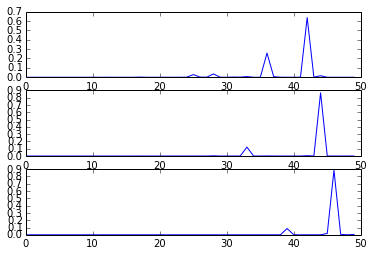

In [15]:
g = gate_fn(input, i_s,  i_w, i_t, q, q_w, 0)

for i in xrange(ep_pass):
    plt.subplot(ep_pass, 1, i+1)
    plt.plot(np.arange(len(g[ep_pass-i-1])), g[ep_pass-i-1])